This tutorial contains some important advices for considering when you model a custom DAG.

We will build step-by-step a naive model, underlying important comments for each part.

---

The model is the following:

* `th1` is a vector of `size_1` independent variables drawn from a uniform in `[-a, a]`
* `th2` is a vector of `size_2` independent variables drawn from a uniform in `[-b, b]`
* simulator just adds some uniform noise in `[-0.2,0.2]` at each variable of the vectors `th1` and `th2`
```
def fn(th1, th2, batch_size, random_state):
    x = np.concatenate((th1, th2), -1)
    size = x.shape[1]
    for i in range(size):
        x += ss.uniform.rvs(loc=-0.2, scale=.4)
    return x
```
* the observed values is a vector of zeros `x0 = np.zeros((1,size_1+size_2))`
* `sum1` computes the mean of simulator's outcome
* `sum2` computes the sum of simulator's outcome
* `d` is the euclidean distance between the summary statistics

---

The model will be build incrementally, using the four basic modelling tools of `elfi`:

* `elfi.Prior`
* `elfi.Simulator`
* `elfi.Summary`
* `elfi.Distance`

In [61]:
import scipy.stats as ss
import numpy as np
import elfi

### Prior

* Prior definition `elfi.Prior(distribution, *params, size=None, **kwargs)`

* `distribution` can be any class that implements an funtion with the following signature `rvs(*params, size=None, **kwargs)`

* an easier choice is to pass a string or an object from `scipy.stats`

#### Prior parameter `*params`

* Parameters `*params` of `elfi.Prior()` are passed to `params` of `rvs()` when `elfi.Prior`is constructed

In the following snippet we create the prior class once and we create two different objects passing different parameter `lim`

In [62]:
class prior:
    def rvs(self, lim, size=None, random_state=None):
        print("lim:[%d, %d]" % (-lim,lim))
        return ss.uniform.rvs(loc=-lim, scale=2*lim, size=size, random_state=random_state)

m = elfi.ElfiModel()
th1 = elfi.Prior(prior(), 1, model=m, name='th1')
th2 = elfi.Prior(prior(), 2, model=m, name='th2')

print("Parameters th1")
output = m.generate(outputs=['th1'])

print("Parameters th2")
output = m.generate(outputs=['th2'])

Parameters th1
lim:[-1, 1]
Parameters th2
lim:[-2, 2]


#### Prior parameter `size`

* Parameter `size` of `elfi.Prior()` corresponds to the dimension of the prior distribution

* By default, it is converted to `(1, size)` before passed as the `size` of `rvs()`. The added dimension is the `batch_size`.
* If `batch_size` is passed explicitly at `m.generate()` then `size` becomes `(batch_size, size)` before passed to `rvs()`. 
* If parameter `size` is not defined at `elfi.Prior()` creation, then rvs produces output of shape `(1, )`. If `batch_size` is explicitly defined, then `rvs` outputs tensor of shape `(batch_size,)`

As we said, we want `th1` to be of `size_1` and `th2` of `size_2`. We will use the `size` parameter of `elfi.Prior()` to achieve that.

In [63]:
class prior:
    def rvs(self, lim, size=None, random_state=None):
        return ss.uniform.rvs(loc=-lim, scale=2*lim, size=size, random_state=random_state)

# parameters
size_1 = 2
size_2 = 3
batch_size = 4
seed = 123

# model definition
m = elfi.ElfiModel()
th1 = elfi.Prior(prior(), 1, size=size_1, model=m, name='th1')
th2 = elfi.Prior(prior(), 2, size=size_2, model=m, name='th2')

# without batch_size passed 
output = m.generate(outputs=['th1', 'th2'])
print("shapes (without batch_size)")
print("th1: ", output['th1'].shape)
print("th2: ", output['th2'].shape)

print("\n")

# with batch_size passed
output = m.generate(outputs=['th1', 'th2'], batch_size=batch_size)
print("shapes (with batch_size)")
print("th1: ", output['th1'].shape)
print("th2: ", output['th2'].shape)

shapes (without batch_size)
th1:  (1, 2)
th2:  (1, 3)


shapes (with batch_size)
th1:  (4, 2)
th2:  (4, 3)


##### Prior  parameter `random_state`

* It is defined under the hood when `m.generate()` is called
* If seed is set (e.g. `m.generate(seed=123)`) the `random_state` is consistent between different runs

In the following snippet, we see that samples are consistent when `seed` is passed as parameter.

In [64]:
print("First run")
output = m.generate(outputs=['th1', 'th2'], batch_size=batch_size, seed=seed)
print("th1: ", output['th1'])
print("th2: ", output['th2'])

print("\n")

print("Second run")
output = m.generate(outputs=['th1', 'th2'], batch_size=batch_size, seed=seed)
print("th1: ", output['th1'])
print("th2: ", output['th2'])

First run
th1:  [[ 0.45606018  0.18088245]
 [-0.52569846  0.39917864]
 [ 0.73217565 -0.29982736]
 [-0.25652047  0.11882121]]
th2:  [[-0.65495866  0.48015155  1.25584115]
 [-1.10834104  0.72773289 -1.58440544]
 [ 0.35912361  0.70650383  1.64151854]
 [ 0.50744294 -0.09357122  1.97178184]]


Second run
th1:  [[ 0.45606018  0.18088245]
 [-0.52569846  0.39917864]
 [ 0.73217565 -0.29982736]
 [-0.25652047  0.11882121]]
th2:  [[-0.65495866  0.48015155  1.25584115]
 [-1.10834104  0.72773289 -1.58440544]
 [ 0.35912361  0.70650383  1.64151854]
 [ 0.50744294 -0.09357122  1.97178184]]


##### Prior parameters `**kwargs`

Can be something in the following list:
* `name=<node name>`, node's name, if not defined the name is created automatically
* `model=elfi.ElfiModel()` if set (as in the examples above) the node is attached to the specific model

## Simulator

`elfi.Simulator(fn, *params, **kwargs)`

`fn` can be any function following the signature `fn(*params, batch_size, random_state)`

#### Parameter `*params`

* `*params` of `elfi.Simulator` are passed unchanged to `*params` of `fn`
* Normally, as `*params` we pass the `elfi.Prior` nodes and maybe some other hyperparameters. 
* `*params` are the calls to `prior.rvs()`, so they are `numpy.arrays` of shape `(batch_size, size)`, where `size` was defined at prior definition

#### Parameters `batch_size`, `random_state`

* They behave exactly as in the case of `elfi.Prior`; they are set at `m.generate()`

#### Parameters **kwargs 

* `name=<node name>`, node's name, if not defined the name is created automatically
* `model=elfi.ElfiModel()` if set (as in the examples above) the node is attached to the specific model
* `observed=<np.array>`, array with observations must be of `shape=(N,F)`

In [65]:
def fn(th1, th2, batch_size, random_state):
    x = np.concatenate((th1, th2), -1)
    size = x.shape[1]
    for i in range(size):
        x += ss.uniform.rvs(loc=-0.2, scale=.4)
    return x

class prior:
    def rvs(self, lim, size=None, random_state=None):
        return ss.uniform.rvs(loc=-lim, scale=2*lim, size=size, random_state=random_state)

# parameters
size_1 = 2
size_2 = 3
batch_size = 4
seed = 123

# observation
observed = np.zeros((1, size_1 + size_2))

# model
m = elfi.ElfiModel()
th1 = elfi.Prior(prior(), 1, size=size_1, model=m, name='th1')
th2 = elfi.Prior(prior(), 2, size=size_2, model=m, name='th2')
sim = elfi.Simulator(fn, th1, th2, name="sim", model=m, observed=observed)

# run model
output = m.generate(outputs=['th1', 'th2', 'sim'], batch_size=batch_size, seed=seed)

# outputs
print("Shapes of ouputs")
print("th1:     ", output['th1'].shape)
print("th2     :", output['th2'].shape)
print("sim     :", output['sim'].shape)
print("observed:", observed.shape)

Shapes of ouputs
th1:      (4, 2)
th2     : (4, 3)
sim     : (4, 5)
observed: (1, 5)


### Summary Statistics

In [66]:
class prior:
    def rvs(self, lim, size=None, random_state=None):
        return ss.uniform.rvs(loc=-lim, scale=2*lim, size=size, random_state=random_state)


def fn(th1, th2, batch_size, random_state):
    x = np.concatenate((th1, th2), -1)
    size = x.shape[1]
    for i in range(size):
        x += ss.uniform.rvs(loc=-0.2, scale=.4)
    return x

def sum1(x):
    return np.mean(x, 1)

def sum2(x):
    return np.sum(x, 1)


# parameters
size_1 = 2
size_2 = 3
batch_size = 4
seed = 123

# observation
observed = np.zeros((1, size_1 + size_2))

# model
m = elfi.ElfiModel()
th1 = elfi.Prior(prior(), 1, size=size_1, model=m, name='th1')
th2 = elfi.Prior(prior(), 2, size=size_2, model=m, name='th2')
sim = elfi.Simulator(fn, th1, th2, name="sim", model=m, observed=observed)
sum1 = elfi.Summary(sum1, sim, model=m, name='sum1')
sum2 = elfi.Summary(sum2, sim, model=m, name='sum2')

# run model
output = m.generate(outputs=['th1', 'th2', 'sim', 'sum1', 'sum2'], batch_size=batch_size, seed=seed)

# outputs
print("Shapes of ouputs")
print("th1:     ", output['th1'].shape)
print("th2     :", output['th2'].shape)
print("sim     :", output['sim'].shape)
print("observed:", observed.shape)
print("sum1    :", output['sum1'].shape)
print("sum2    :", output['sum2'].shape)

Shapes of ouputs
th1:      (4, 2)
th2     : (4, 3)
sim     : (4, 5)
observed: (1, 5)
sum1    : (4,)
sum2    : (4,)


###  Distance

* x shape: `(batch_size, F)`
* y shape: shape of observation must be `(1, F)`

The distance is be computed row-wise


In [67]:
class prior:
    def rvs(self, lim, size=None, random_state=None):
        return ss.uniform.rvs(loc=-lim, scale=2*lim, size=size, random_state=random_state)


def fn(th1, th2, batch_size, random_state):
    x = np.concatenate((th1, th2), -1)
    size = x.shape[1]
    for i in range(size):
        x += ss.uniform.rvs(loc=-0.2, scale=.4)
    return x

def sum1(x):
    return np.mean(x, 1)

def sum2(x):
    return np.sum(x, 1)


# parameters
size_1 = 2
size_2 = 3
batch_size = 4
seed = 123

# observation
observed = np.zeros((1, size_1 + size_2))

# model
m = elfi.ElfiModel()
th1 = elfi.Prior(prior(), 1, size=size_1, model=m, name='th1')
th2 = elfi.Prior(prior(), 2, size=size_2, model=m, name='th2')
sim = elfi.Simulator(fn, th1, th2, name="sim", model=m, observed=observed)
sum1 = elfi.Summary(sum1, sim, model=m, name='sum1')
sum2 = elfi.Summary(sum2, sim, model=m, name='sum2')
d = elfi.Distance('euclidean', sum1, sum2, model=m, name="d")

# run model
output = m.generate(outputs=['th1', 'th2', 'sim', 'sum1', 'sum2', 'd'], batch_size=batch_size, seed=seed)

# outputs
print("Shapes of ouputs")
print("th1:     ", output['th1'].shape)
print("th2     :", output['th2'].shape)
print("sim     :", output['sim'].shape)
print("observed:", observed.shape)
print("sum1    :", output['sum1'].shape)
print("sum2    :", output['sum2'].shape)
print("d       :", output['d'].shape)

Shapes of ouputs
th1:      (4, 2)
th2     : (4, 3)
sim     : (4, 5)
observed: (1, 5)
sum1    : (4,)
sum2    : (4,)
d       : (4,)


### shapes of all tensors

* prior_1
  * output: `(batch_size, D1)`, `D1 = size_1` parameter of `elfi.Prior`
* prior_2
  * output: `(batch_size, D2)`, `D2 = size_1` parameter of `elfi.Prior`
* simulator:
  * input: `(batch_size, D1), (batch_size, D2)`
  * output: `(batch_size, F)`
* observed:
  * is: `(1, F)` 
* summary_1
  * input: 
    * from simulator: `(batch_size, F)`
    * from observation: `(1, F)`
  * output: `(batch_size, F1)`
* summary_2
  * input: 
    * from simulator: `(batch_size, F)`
    * from observation: `(1, F)`
  * output: `(batch_size, F2)`
* dist 
  * input: 
    * from simulator: `(batch_size, F1 + F2)`
    * from observation: `(1, F1 + F2)`
  * output: `(batch_size)`


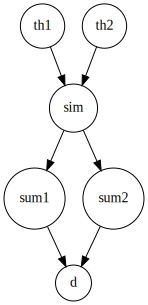

In [68]:
elfi.draw(d)

### Modelling limitations

In the tutorial above, we showed how to build a data generation process at `elfi`. We underlined some crucial directives, mostly on the appropriate handling of the shapes of all tensors. There are though some modelling limitations:

* we cannot model a scenario where the observed data are of the form input-output: `x, y` as in many machine learning scenarios
* we cannot model the case where we many different observation examples, i.e. `x0` has shape `(N,F)` where `N` is the number of distinct observations. There are workarounds for this case (handling correctly the summary statistics), but the situation is not modelled in a straightforward way